In [1]:
import sys
sys.path.append("../.")
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import scipy
import subprocess
from natsort import natsorted
from utls.preprocessing import *
from InterfaceDeclaration import LPBFInterface

alphabet = list(string.ascii_lowercase)

project_name = ["MuSIC", "MaPS", "MuSIC_EXP1"]
if os.name == "posix":
    data_dir = subprocess.getoutput("echo $DATADIR")
elif os.name == "nt":
    data_dir = subprocess.getoutput("echo %datadir%")
music_dir = os.path.join(data_dir, "MuSIC")
if not os.path.exists(music_dir):
    project_name[0] = "2024-MUSIC"
daq_dir = os.path.join(data_dir, *project_name, "Acoustic Monitoring")
lmq_dir = os.path.join(data_dir, *project_name, "LMQ Monitoring")
del music_dir

sampling_rate_daq: int = int(1.25 * 1e6)
sampling_rate_lmq: int = int(0.1 * 1e6)
tdms_daq_list = natsorted(
    [i for i in os.listdir(daq_dir) if i.split(".")[-1] == "tdms"]
)
bin_lmq_list = natsorted([i for i in os.listdir(lmq_dir) if i.split(".")[-1] == "bin"])
lmq_channel_name = [
    "Vector ID",
    "meltpooldiode",
    "X Coordinate",
    "Y Coordinate",
    "Laser power",
    "Spare",
    "Laser diode",
    "Varioscan(focal length)",
]
process_regime = [
    [0,    59, "Base"  ], 
    [60,  129, "KH"    ], 
    [130, 199, "Normal"], 
    [200, 269, "RLoF"  ], 
    [269, 339, "LoF"   ] 
]

In [32]:
layer_i = 129
tdms_file_path =os.path.join(daq_dir,tdms_daq_list[layer_i])
bin_file_path = os.path.join(lmq_dir,bin_lmq_list[layer_i])
data_daq = TdmsFile(tdms_file_path)
data_lmq = read_bin_file(bin_file_path)
_bin_name = os.path.split(bin_file_path)[-1].split(".")[0]

_mic = (data_daq.groups()[0]).channels()[0].data
_ae = (data_daq.groups()[0]).channels()[1].data
_photodiode = (data_daq.groups()[0]).channels()[2].data
_laserdiode = data_lmq[:,6]
_laserpower = data_lmq[:,4]
_daq_t=np.linspace(0,len(_mic)/sampling_rate_daq,len(_mic))
_lmq_t=np.linspace(0,len(_laserdiode)/sampling_rate_lmq,len(_laserdiode))

pulse_on_thershold = 0.2
sliced_indices_daq = np.asarray(pulse_signal_slicer_by_interval( _photodiode, sampling_rate_daq, pulse_on_thershold=pulse_on_thershold, index_only=True,binary=False))
sliced_indices_lmq = np.asarray(pulse_signal_slicer_by_interval( _laserdiode, sampling_rate_lmq, pulse_on_thershold=pulse_on_thershold, index_only=True,binary=False))
while len(sliced_indices_daq)!=len(sliced_indices_lmq)!=5:
    pulse_on_thershold -= 0.05
    sliced_indices_daq = np.asarray(pulse_signal_slicer_by_interval( _photodiode, sampling_rate_daq, pulse_on_thershold=pulse_on_thershold, index_only=True))
    sliced_indices_lmq = np.asarray(pulse_signal_slicer_by_interval( _laserdiode, sampling_rate_lmq, pulse_on_thershold=pulse_on_thershold, index_only=True))

sliced_indices_lmq_0 = np.zeros([5,2],dtype=int)
for i, vid in enumerate(np.unique(data_lmq[:,0])[1:-1]):
    sliced_indices_lmq_0[i,0], sliced_indices_lmq_0[i,1] = find_first_and_last_indices(data_lmq[:,0], vid)

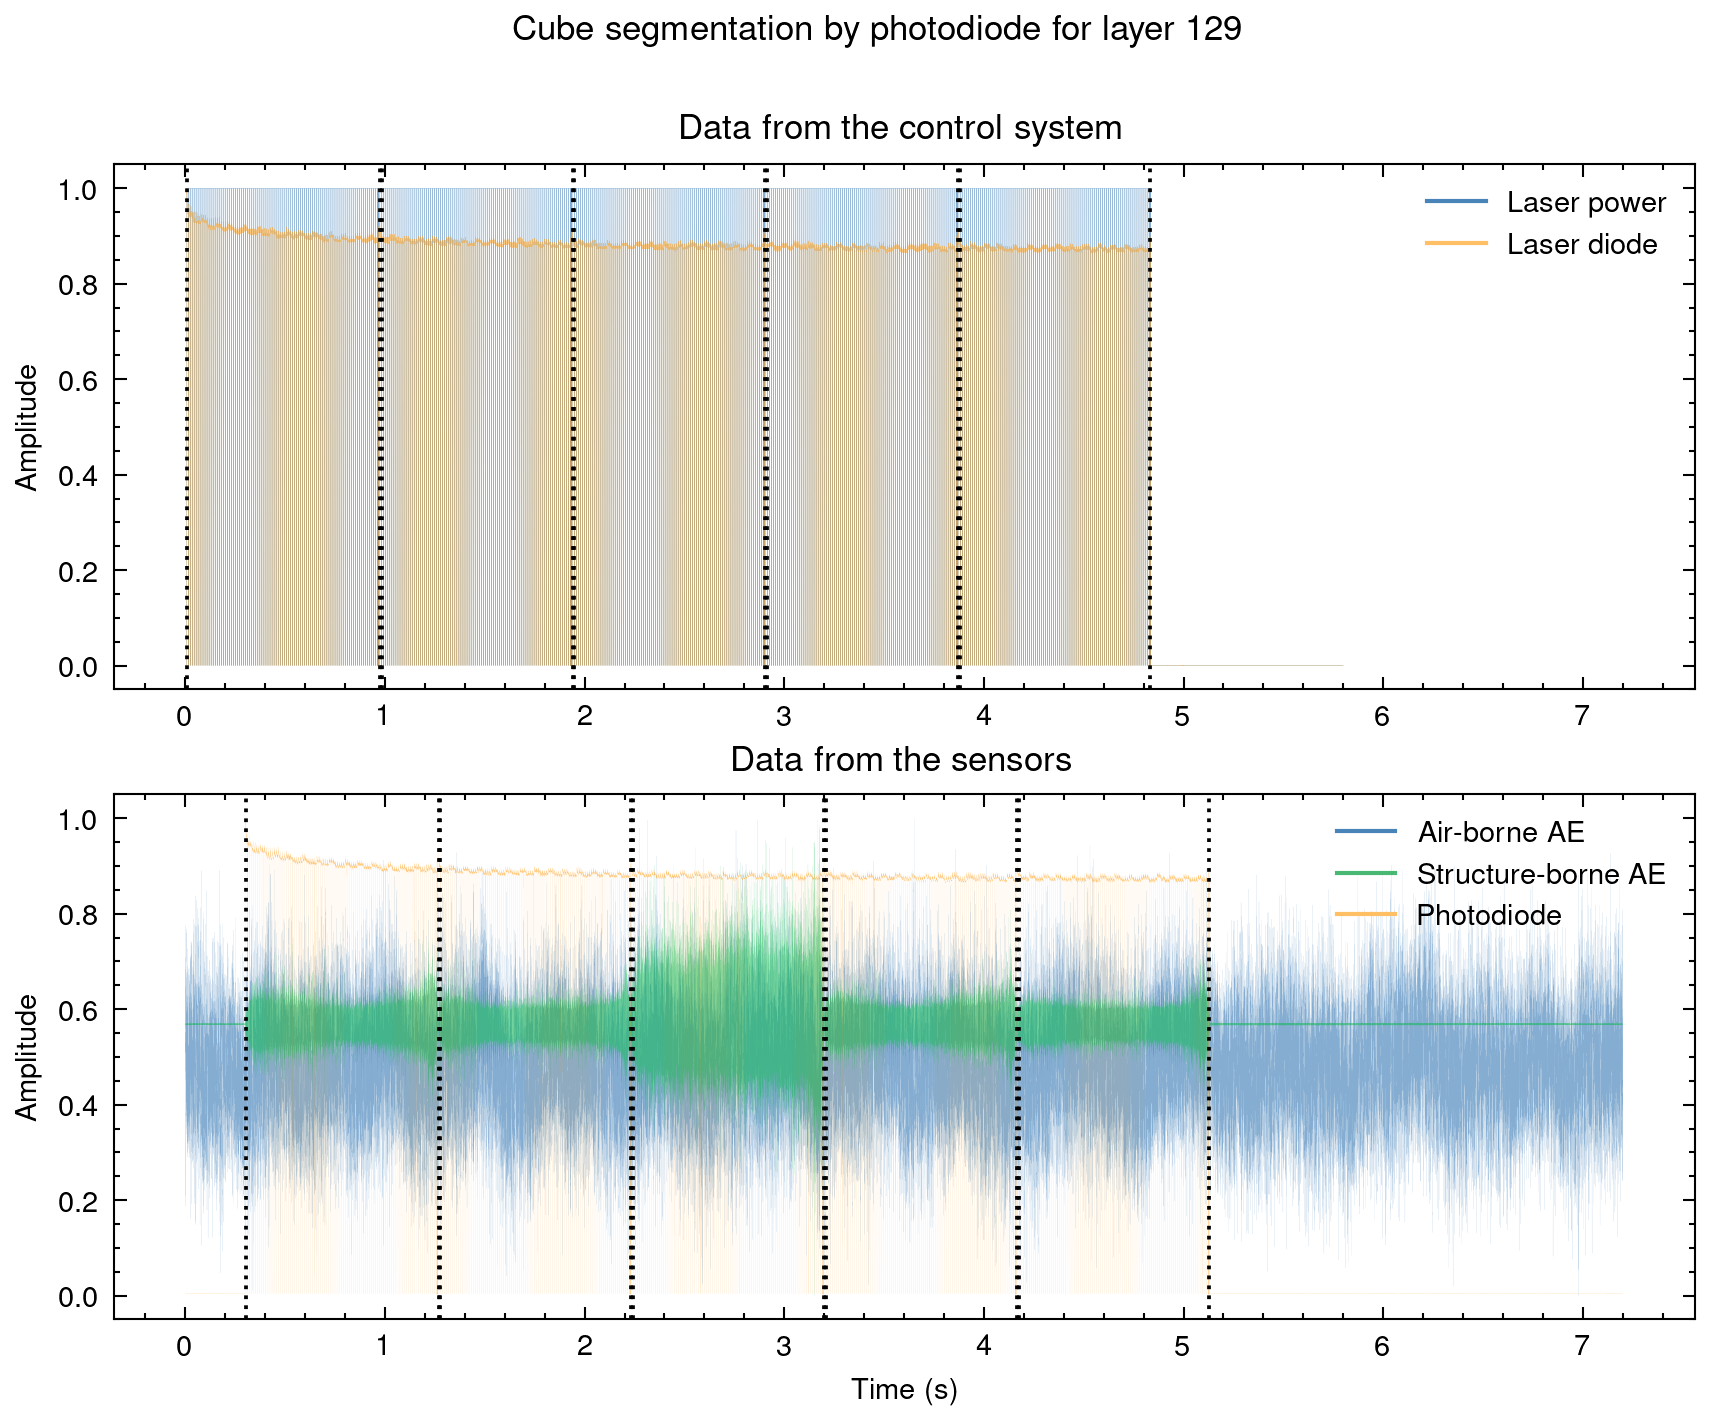

In [49]:
lw=0.02
alpha=0.5
fig,ax = plt.subplots(figsize=(6.8,5),nrows=2)
ax[1].plot(_daq_t,normalize_array(_mic),alpha=alpha,lw=lw,label='Microphone',color=cm_std[0])
ax[1].plot(_daq_t,normalize_array(_ae),alpha=alpha,lw=lw,label='Structure-borne AE',color=cm_std[1])
ax[1].plot(_daq_t,normalize_array(_photodiode),alpha=alpha,lw=lw,label='Photodiode',color=cm_std[2])
[ax[1].axvline(x = _daq_t[i], color = 'black', label = 'Segmentation line',lw=0.9,linestyle=':') for i in sliced_indices_daq.flatten()]
ax[1].set_ylabel(f"Amplitude")
ax[1].set_xlabel(f"Time (s)")
ax[1].set_title("Data from the sensors")
legend_elements1 = [
    plt.Line2D([], [], label='Air-borne AE', color="#4984B8", linestyle='-'),
    plt.Line2D([], [], label='Structure-borne AE', color='#49B873', linestyle='-'),
    plt.Line2D([], [], label='Photodiode', color="#FFBF65", linestyle='-'),
]

ax[0].plot(_lmq_t,normalize_array(_laserpower),alpha=alpha,lw=0.1,label='laser power',color=cm_std[0])
ax[0].plot(_lmq_t,normalize_array(_laserdiode),alpha=alpha,lw=lw*5,label='laser diode',color=cm_std[2])
ax[0].set_xlim(ax[1].get_xlim())
[ax[0].axvline(x = _lmq_t[i], color = 'black', label = 'Segmentation line',lw=0.9,linestyle=':') for i in sliced_indices_lmq.flatten()]
legend_elements0 = [
    plt.Line2D([], [], label='Laser power', color="#4984B8", linestyle='-'),
    # plt.Line2D([], [], label='Structure-borne AE', color='#49B873', linestyle='-'),
    plt.Line2D([], [], label='Laser diode', color="#FFBF65", linestyle='-'),
]

ax[0].set_ylabel(f"Amplitude")
ax[0].set_title("Data from the control system")

fig.suptitle(f"Cube segmentation by photodiode for layer {layer_i}")
ax[0].legend(handles=legend_elements0)
ax[1].legend(handles=legend_elements1)
plt.savefig(f"../outputs/raw_segmented_{layer_i}.png",dpi=300)
plt.show()